<a href="https://colab.research.google.com/github/yajima-yasutoshi/DataMinig/blob/main/20231213/%E5%88%86%E9%A1%9E2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データマイニング第11回（2023/12/13）

#本日の講義の目的

分類手法に関する説明を行う。特に、2値の分類問題に対する
ロジスティック回帰による予測モデルの構築法を理解する。

## 分類手法が活用されるシーン

* 解約、離脱の予測
> 携帯電話や動画配信サービスなどのサブスクリプションサービスでは、将来解約する可能性を予測し、解約しそうな顧客に対しては割引などを実施し、解約を未然に防ぐ施策が行われている。

* 病気の診断
> 検査の結果や過去の病歴などから病気にかかっているのか/いないのか、あるいは将来の発病をを予測する。近年は画像データを使う場合も多い

* 不正検知
> クレジットカードや金融取引などの不正利用を予測。

* 倒産や破産の予測
> 金融機関で融資を行う際には、借り手の信用リスクを判断し、返済が可能か/そうでないかを予測している。

この例のように、ある事象の発生するかしないかを予測する問題を
**2値の分類問題**と呼び、代表的なAIモデルがロジスティック回帰である。

線形回帰は人数や売上個数といった数値予測であったが、
ここで扱うロジスティック回帰は2値のカテゴリ予測（分類）である。

データマイニングでは、
**予測の目的に応じて適切な手法を選ぶ**必要がある。

## 準備


In [1]:
# インストール
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 36.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=b947e8ed70dbf209835fee9601ca2701c8dfa4cdd9a7d213f7cb23fb9964e176
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


## 必要なライブラリーのインポート

In [2]:
# 必要なライブラリをインポート
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

In [3]:
# 必要なライブラリのインポート
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 分類（ロジスティック回帰）に必要なライブラリー
from sklearn.linear_model import LogisticRegression

# その他必要なライブラリー
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### 【参考】ロジスティック回帰ライブラリー
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

## Cancer データ

sklean ライブラリーに格納されているサンプルデータ（cancer data）を使いロジスティック回帰の説明を行う。

In [ ]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
df['diagnosis'] = cancer.target
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

これは、癌の疑いのある細胞に関連した30項目（サイズ、形状、など細胞の状態）と、
そこから医師などが判断した癌の診断結果（'diagnosis'）のデータである。

このデータでは全ての項目は数値型となっており、
特に診断結果（'diagnosis'）は

* 悪性の場合には 0
* 良性の場合には 1

が入力されており、
このような項目を**2値**の項目と呼ぶ。

このデータを学習させて、
細胞に関する30項目を説明変数として
**癌の診断（良性か悪性かの分類）を行うAIを構築**する。

### 基礎集計

In [ ]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


diagnosis の分布の確認する。

<Axes: xlabel='diagnosis', ylabel='count'>

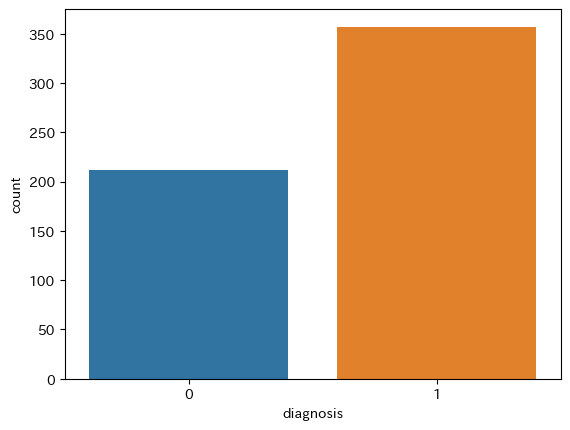

In [ ]:
sns.countplot(x='diagnosis', data=df)

diagnosis は数値型の項目ではあるが、値は 0 と 1 の2値となっていることが確かめられる。

ヒストグラムを作成して、各項目の分布を確認する。

<Axes: xlabel='mean radius', ylabel='Count'>

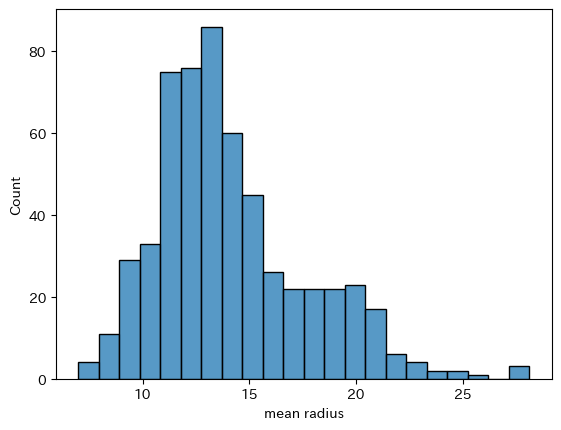

In [ ]:
sns.histplot(data=df, x='mean radius')

hue を使いdiagnosisで色分けしてみる

<Axes: xlabel='mean radius', ylabel='Count'>

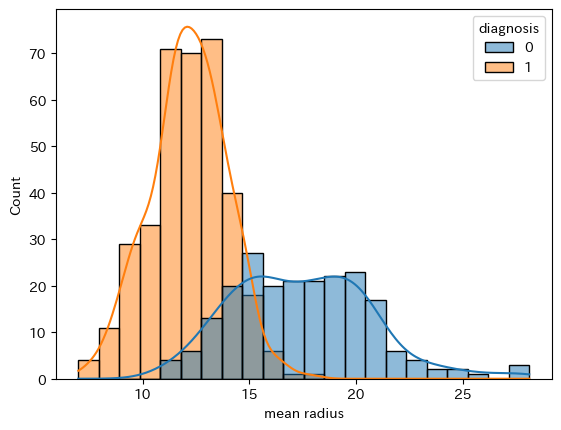

In [ ]:
sns.histplot(data=df, x='mean radius', hue='diagnosis', kde=True)

このグラフからは、mean radius がおよそ18を超えるとほぼ全てが悪性、
逆に10を下回るとほぼ全てが良性になっていることが分かる。

一方で、10から18の間では、良性も悪性もあり、
この項目だけでは細胞が悪性か良性かを判断できないことが分かる。

<Axes: xlabel='radius error', ylabel='Count'>

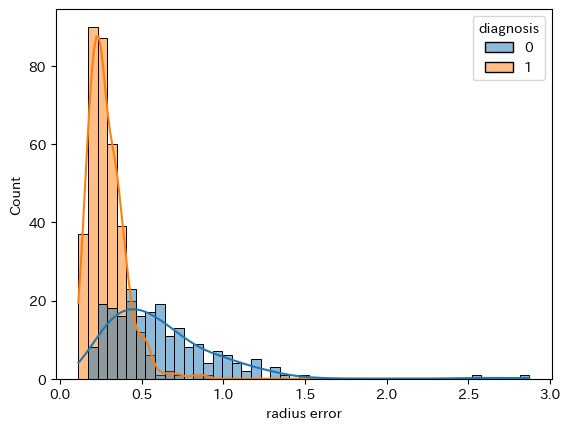

In [ ]:
sns.histplot(data=df, x='radius error', hue='diagnosis', kde=True)

<Axes: xlabel='mean compactness', ylabel='Count'>

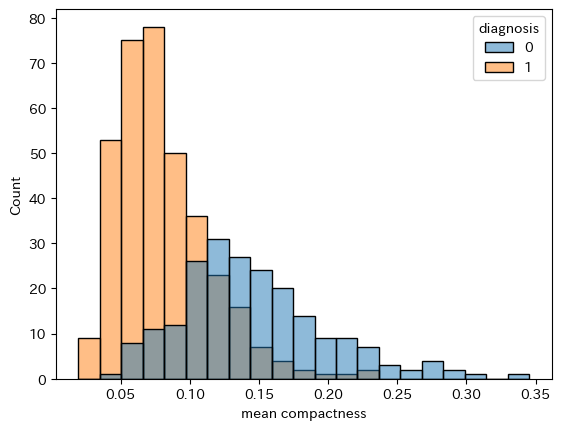

In [ ]:
# sns.histplot(data=df, x='fractal dimension error', hue='diagnosis', kde=True)
sns.histplot(data=df, x='mean compactness', hue='diagnosis')

<Axes: xlabel='mean area', ylabel='Count'>

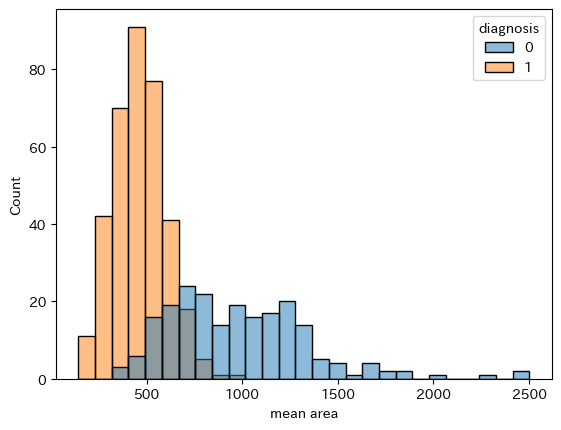

In [ ]:
sns.histplot(data=df, x='mean area', hue='diagnosis')
# sns.boxplot(data=df, y='mean area')

# ロジスティック回帰
30項目の数値データと癌の診断結果（diagnosis）から、
悪性か良性かを分類するAIを構築する。

悪性か良性かといった2値の分類を行いたい場合に用いられる手法として、
最も基本となる**「ロジスティック回帰」**の使い方を説明する。

## ロジスティックモデル構築全体の流れ

ロジスティックモデル構築の流れは以下のようになる。

0. 基礎集計

1. 変数の設定

  説明変数と目的変数を設定する。

2. データの分割

  データ全体を、学習用データと評価用データに分割する。
    train_test_split() を利用する。

3. 説明変数の標準化

  変数の平均を0、分散を1に標準化する。
  StandardScaler の fit() と transform() を使うことで実現される。

4. モデルの学習

   学習用データを用いてモデルを構築する。fit() を使う。

5. 評価用データでモデルの精度を評価

   1. 評価用の説明変数で予測を行う。predict() を使う。
   2. 予測と正解を比較して精度を求める。accuracy_score() を使う。



## 変数の設定
* **説明変数：** 予測する元になる項目。上のデータでは30項目の数値型データがある。
* **目的変数：** 予測の対象となる項目。上のデータでは diagnosis である。

ロジスティック回帰を適応するためには、
* 説明変数が数値型のデータで、かつ
* 目的変数が2値の項目（カテゴリ変数、数値型変数どちらでも良い）

となる必要がある。
上で準備したデータはこの条件を満足している。


説明変数と目的変数を設定

説明変数と目的変数をそれぞれ変数 X と y にセットする。

In [ ]:
X = df[ ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension']]
y = df[['diagnosis']]

上のプログラムでは、30項目全てを使う場合には多くの項目を記述する必要があるが、以下のようにすることもできる。

In [ ]:
# 項目'diagnosis'は変数dfの最後にある項目なので、それを除くと説明変数のみとなる
X = df.iloc[:,:-1]
y = df[['diagnosis']]

## データの分割

予測モデルの精度を事前に確認するために、以下のように全データを「学習用データ」と「検証用データ」にランダム分け、
学習用データでモデルを構築したのちに、
検証用データで精度（AIの予測が医師の判断とどの程度一致するか）を確認する
ことが一般的である。

```
train_test_split
```

を用いると、データを学習用と検証用に分割することができる。
一般的には検証用のレコード数を全体の **2割～3割** 程度が適切とされている。

検証用のレコードの割合を2割にする場合は以下のように指定する。

```
test_size=0.2
```


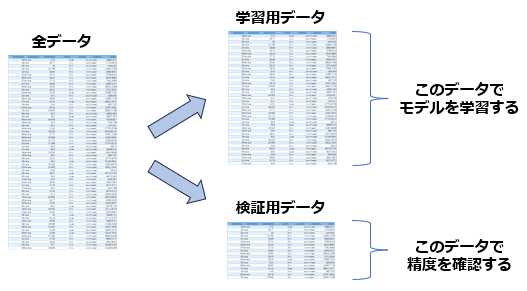

以下のように train_test_split を用い、
説明変数 X と目的変数 y から
学習用データと検証用データを作成する。

```
A, B, C, D  = train_test_split(X, y, test_size=0.2, random_state=0)
```

A, B, C, Dは以下のようにセットされる。

データ | 説明変数  | 目的変数
--     | --        | --
学習用データ | A   | C
検証用データ | B   | D

In [ ]:
# 必要なライブラリのインポート
from sklearn.model_selection import train_test_split

# データを学習用データと検証用に分割
# test_size は、0.2 から 0.3 程度が良いとされる
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

shape を使ってレコード数を確認する。

In [ ]:
X.shape

(569, 30)

In [ ]:
X_val.shape

(114, 30)

## 説明変数の標準化

ロジスティック回帰では、説明変数の標準化を行う。

> 標準化とは、データを変換して、平均 0、分散 1 にすることである。

標準化は、
StandardScaler の fit() と transform() を使うことで実現される。

In [ ]:
# 必要なライブラリのインポート
from sklearn.preprocessing import StandardScaler

# 準備のための手順
scaler = StandardScaler()
scaler.fit(X_train)

# 標準化後のものは別の変数にセットすると良い
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
# X_train_scaled では数値が標準化されたことを確認する
pd.DataFrame(X_train_scaled, columns=X_train.columns).describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,...,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02
mean,-9.135549e-16,-3.341893e-15,3.216963e-15,-2.201902e-15,-1.456222e-15,5.348591e-16,6.871182e-16,4.450652e-16,-5.669702e-15,6.715019e-16,...,-4.841060e-16,4.841060e-16,-1.460126e-15,1.249306e-16,5.936155e-15,-3.708877e-16,-1.358620e-15,2.654775e-16,-2.137484e-15,1.989129e-15
std,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,...,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00
min,-2.019404e+00,-2.272988e+00,-1.977589e+00,-1.426379e+00,-3.176344e+00,-1.664312e+00,-1.125696e+00,-1.262871e+00,-2.738225e+00,-1.865718e+00,...,-1.704360e+00,-2.218398e+00,-1.673608e+00,-1.188201e+00,-2.711807e+00,-1.468356e+00,-1.341360e+00,-1.754014e+00,-2.128278e+00,-1.598903e+00
25%,-6.873871e-01,-7.420774e-01,-6.883840e-01,-6.577342e-01,-7.082998e-01,-7.367713e-01,-7.403181e-01,-7.254573e-01,-6.975035e-01,-7.022156e-01,...,-6.624319e-01,-7.439783e-01,-6.767688e-01,-6.257607e-01,-7.105576e-01,-6.807320e-01,-7.569093e-01,-7.585201e-01,-6.518526e-01,-6.814765e-01
50%,-2.357361e-01,-9.697672e-02,-2.403944e-01,-3.131017e-01,-3.433938e-02,-2.188714e-01,-3.517235e-01,-3.963173e-01,-6.354630e-02,-1.656097e-01,...,-2.878293e-01,-5.394673e-02,-2.932556e-01,-3.516681e-01,-3.801757e-02,-2.619431e-01,-1.970300e-01,-2.427267e-01,-1.416994e-01,-2.181271e-01
75%,4.551909e-01,5.866375e-01,4.871769e-01,3.009759e-01,6.519540e-01,5.151506e-01,4.775784e-01,6.589276e-01,5.320447e-01,4.590848e-01,...,4.409060e-01,6.229571e-01,5.074669e-01,2.583182e-01,5.659411e-01,5.435962e-01,5.549081e-01,7.103914e-01,4.542741e-01,4.568064e-01
max,3.963628e+00,3.528104e+00,3.980919e+00,5.163006e+00,3.503046e+00,4.125777e+00,4.366097e+00,3.955644e+00,4.496561e+00,5.105021e+00,...,4.049783e+00,3.938555e+00,4.261315e+00,5.758096e+00,3.988374e+00,5.270909e+00,4.936910e+00,2.695096e+00,5.934052e+00,6.968987e+00


##ロジスティック回帰モデルを学習する

学習を行う関数は fit であり、以下のように用いる

```
model = LogisticRegression()
model.fit(説明変数, 目的変数)
```



In [ ]:
# 分類（ロジスティック回帰）に必要なライブラリー
from sklearn.linear_model import LogisticRegression

# ロジスティック回帰モデルの準備のための命令
model = LogisticRegression()

# モデルを学習
model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

### 参考

上の例では警告メッセージが表示されるが特に問題はない。
以下のようにプログラムすることで警告メッセージが出力されなくなる。

In [ ]:
# モデルを学習
model.fit(X_train_scaled, y_train.values.ravel()  )

LogisticRegression()

線形回帰と同様、回帰係数が model.coef_ により得られる。

In [ ]:
model.coef_

array([[-0.33876214, -0.48939456, -0.330574  , -0.40274765, -0.19380529,
         0.44575519, -0.67211017, -0.84612924, -0.33758483,  0.21274935,
        -1.39050559,  0.0394851 , -0.84507703, -0.97876119,  0.25537755,
         0.6623816 ,  0.12210568, -0.2273378 ,  0.12585617,  0.86832724,
        -0.93114793, -1.04054114, -0.76764961, -0.9005161 , -0.53303391,
        -0.0284274 , -0.86650877, -0.97095476, -0.51867962, -0.60055403]])

説明変数が30項目あるので、それぞれに対応する回帰係数が得られる。

<Axes: >

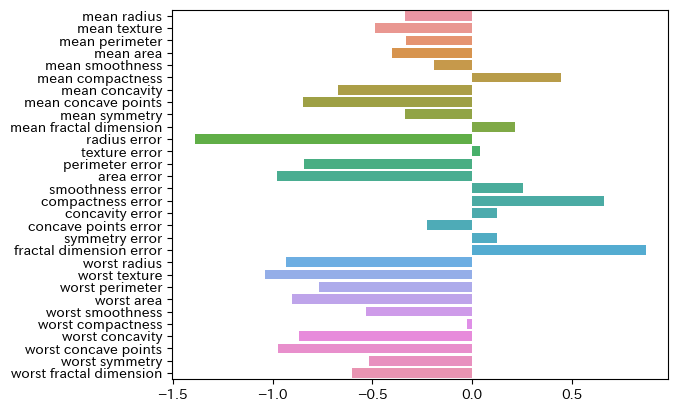

In [ ]:
sns.barplot(x=model.coef_[0], y=X.columns)

回帰係数には正のものと負のものが計算されていることが分かる。


回帰係数は、

* 正であれば、その項目の値が大きくなれば 1 （このデータの場合では良性）になりやすい、

 逆に

* 負であれば、項目の値が大きくなれば 0 （このデータの場合では悪性）になりやすい、

と解釈ができる。

### ロジスティック関数

ロジスティック回帰では、以下の関数が計算される。

$$ y = \frac{1}{1+ e^{-(a_1 x_1 + a_2 x_2\cdots + a_{30} x_{30}) }} $$

分母の

$$ a_1 x_1 + a_2 x_2\cdots + a_{30} x_{30} $$

は、重回帰分析で求められた数式と同じ形で、
$x_1, x_2, \ldots, x_{30}$ が30個の変数に対応し、
$a_1, a_2, \ldots, a_{30}$ は回帰係数と呼ばれる。
この例では、説明変数が30個あるので、それらに対応した回帰係数も30個となる。

## 推論

構築したモデルで推論を行うためには、以下のように predict 関数を用いる

```
model.predict(説明変数)
```

評価用として分割したデータに対して予測を行うためには、以下のようにすればよい。

In [ ]:
from sklearn.metrics import accuracy_score

# 評価データで予測
y_pred = model.predict(X_val_scaled)

学習と同様、説明変数には標準化したものを(X_val_scaled)用いる。

In [ ]:
y_pred

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1])

## 精度の評価

評価用のデータセットを用いて精度の評価を行う。


In [ ]:
compare = y_val.copy()
compare['Pred'] = y_pred
compare

,diagnosis,Pred
512,0,0
457,1,1
439,1,1
298,1,1
37,1,1
...,...,...
213,0,1
519,1,1
432,0,0
516,0,0


diagnosis と Pred を比べ、
予測(Pred)がデータ（医師の判断）と一致していれば
正しく予測できたことになる。

評価基準としては正解率を用いる。

正解率は全体に対する正解したデータ数の割合である。

In [ ]:
from sklearn.metrics import accuracy_score

# 評価データで予測
y_pred = model.predict(X_val_scaled)

# 精度を計算
accuracy = accuracy_score(y_val, y_pred)
accuracy

0.9649122807017544

### 混同行列を使った予測精度の確認

混同行列（confusion matrix）とは、正しく予測できたレコード数や正しく予測できなかったレコード数を集計した、以下のような2行2列の表のことである。


 混同行列   | 0 と予測  | 1 と予測
 -- | --        | --
 0 のデータ |  A   | B
 1 のデータ |  C   | D

* A は、0 と予測したレコードの中で実際も 0 であったレコード数
* C は、0 と予測したレコードの中で実際は 1 であったレコード数
* B は、1 と予測したレコードの中で実際は 0 であったレコード数
* D は、1 と予測したレコードの中で実際も 1 であったレコード数

A と D の合計が正しく予測できたレコード数となる。

検証用データの場合で、混同行列を作成する。

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[45,  2],
       [ 2, 65]])

したがって、正解率は以下のように計算できる。

（45+65）÷（45+2+2+65）= 0.9649...



---



---



# Titanic データを使った例

In [ ]:
# データを読み込む
# 変数名を data とした
data = sns.load_dataset("titanic") #タイタニックのデータ
data.info()
data.head(5)

##データの説明

列名 | 意味
---  | ---
survived	| 生存フラグ（0=死亡、1=生存）
pclass	| チケットクラス（1stクラス、2ndクラス、3rdクラス）
sex	| 性別（male=男性、female＝女性）
sge	| 年齢
sibsp	| タイタニックに同乗している兄弟/配偶者の数
parch	| タイタニックに同乗している親/子供の数
fare	| 料金
embarked	| 出港地（タイタニックへ乗った港）(C=Cherbourg、Q=Queenstown、S=Southampton)
class | 乗船クラス
who |男性 or 女性
adult_male | 成人男性であるかどうか
deck | 乗船していたデッキ
embark_town | 出港地
alive | 生存したかどうか
alone | 一人であったかどうか

In [ ]:
# 欠損値を確認する
data.isnull().sum()

In [ ]:
# 欠損値を埋める

# 平均値で欠損値を埋める。
data['age'].fillna(data['age'].mean(), inplace=True)

# 最頻値で欠損値を埋める。
data['embarked'].fillna(data['embarked'].mode()[0], inplace=True)
data['embark_town'].fillna(data['embark_town'].mode()[0], inplace=True)

# 結果を確認
data.isnull().sum()

In [ ]:
# 基本的な統計情報を表示
print(data.describe())

# 生存者数と死亡者数を集計
survived_counts = data['survived'].value_counts()
print("\n生存者数と死亡者数の集計:")
print(survived_counts)

# 乗客のクラスごとの生存率を計算
survival_rate_by_class = data.groupby('pclass')['survived'].mean()
print("\nクラスごとの生存率:")
print(survival_rate_by_class)

# 性別ごとの生存率を計算
survival_rate_by_gender = data.groupby('sex')['survived'].mean()
print("\n性別ごとの生存率:")
print(survival_rate_by_gender)

# 年齢の分布を表示
print("\n年齢の分布:")
print(data['age'].hist())

In [ ]:
# 説明変数と目的変数を選択
# 数値データのみで予測
X = data[[ 'age', 'fare', 'sibsp', 'parch']]
y = data['survived']

In [ ]:
# データを学習用と検証用に分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 準備のための手順
scaler = StandardScaler()
scaler.fit(X_train)

# 標準化後のものは別の変数にセットすると良い
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ロジスティック回帰モデルを作成
model = LogisticRegression()

# モデルを訓練
model.fit(X_train_scaled, y_train)

# テストデータで予測
y_pred = model.predict(X_val_scaled)

# 精度を計算
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# 回帰係数を可視化
sns.barplot(x=model.coef_[0], y=X.columns)
plt.show()

In [ ]:
# カテゴリ変数をOne Hot Encoding
data_encoded = pd.get_dummies(data[['embarked', 'class', 'who', 'adult_male', 'alone']], drop_first=True)

# 説明変数と目的変数を設定
X = pd.concat([data[['age', 'fare', 'sibsp', 'parch']], data_encoded], axis=1)
y = data['survived']

In [ ]:
# データを訓練セットとテストセットに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 準備のための手順
scaler = StandardScaler()
scaler.fit(X_train)

# 標準化後のものは別の変数にセットすると良い
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

# ロジスティック回帰モデルを作成
model = LogisticRegression()

# モデルを訓練
model.fit(X_train_scaled, y_train)

# テストデータで予測
y_pred = model.predict(X_val_scaled)

# 精度を計算
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy}')

# 特徴量の重要度を可視化
sns.barplot(x=model.coef_[0], y=X.columns)
plt.show()

---
---
---


## ハイパーパラメータチューニング

In [ ]:
# 必要なライブラリをインポート
from sklearn.model_selection import GridSearchCV

# パラメータグリッドを設定
param_grid = {'C': [ 0.05, 0.1, 0.15, 0.2, 0.3, 1]}

# GridSearchCVを設定
grid_search = GridSearchCV(LogisticRegression(penalty='l2'), param_grid, cv=5)

# グリッドサーチを実行
grid_search.fit(X_train_scaled, y_train.values.ravel() )

# 最適なパラメータとスコアを出力
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# 最適なパラメータでテストデータを評価
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred)
print(f"Validation set accuracy: {accuracy}")


In [ ]:

# 精度が向上する様子をグラフで示す
scores = grid_search.cv_results_['mean_test_score']
plt.figure(figsize=(10, 6))
sns.lineplot(x=param_grid['C'], y=scores)
plt.xlabel('C (Inverse of regularization strength)')
plt.ylabel('Mean Test Score')
plt.title('Optimizing l2 Penalty with Grid Search')
plt.show()

# その他の参考となるサイト
https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package



https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset
